In [6]:
%load_ext autoreload
%autoreload 2

import os
import cv2
import sys
import random
import rasterio
import json
import copy
import numpy as np
import tifffile as tiff
import matplotlib.image as mpimg
import rasterio 

from random import seed
import scipy
from glob import glob
import matplotlib.pyplot as plt
from rasterio.windows import Window
import math

from keras.optimizers import SGD, Adam, RMSprop
from segmentation_models import Unet, FPN

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger, EarlyStopping, Callback

from keras.models import model_from_json
from keras import backend as K
from keras.layers import Conv2D
from keras import layers
from keras.models import Model
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = "1"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
print("This notebook was built with:")
print("python version: %s " % sys.version)
print("tensorflow version: %s" %  tf.__version__)
print("segmentation_models version: %s" %  segmentation_models.__version__)
print("scipy version: %s" %  scipy.__version__)
print("aeronet version: %s" %  aeronet.__version__)

This notebook was built with:
python version: 3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0] 
tensorflow version: 1.8.0
segmentation_models version: 1.0.1
scipy version: 1.5.3
aeronet version: 0.0.8


In [3]:
from individual_stands_sampling import Generator, f1_score
from save_pred import save_pred, tif2geojson, split_img, reconstruct_pred
from loss_functions import  weighted_categorical_crossentropy, per_stand_loss

### Set path to folders

In [8]:
# directoty with usgs_sentinel folder
dataset_dir = '/home/user/data/projects/research-project/notebooks/Illarionova/'

train_img_list = ['usgs_sentinel/Mandrog/L2A_T36VWN_A010343_20170615T090713',
                 'usgs_sentinel/Mandrog/L2A_T36VWN_A016206_20180730T090554']

val_img_list = ['usgs_sentinel/Left_shore/novoshinsk/L2A_T38VNP_A016606_20180827T083208',
               'usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A016606_20180827T083208']

# add full path to data
for i in range(len(train_img_list)):
    train_img_list[i] = dataset_dir+train_img_list[i]
for i in range(len(val_img_list)):
    val_img_list[i] = dataset_dir+val_img_list[i]

## Set generator with image id

In [9]:
class_0=['Os']                      # aspen
class_1=['B']                       # birch
num_channels = 10
batch_size = 128 

generator = Generator(batch_size=batch_size,class_0=class_0,class_1=class_1,
                      num_channels=num_channels)

generator.IMG_COL = 64 
generator.IMG_ROW = 64 
generator.cloud = True
generator.augm = True               # geometrical augmentation
generator.stands_id = True          # masked pixels outside the individual stand
weights_list = [2., 1.]             # add weights for loss calculation
loss =  generator.weighted_categorical_crossentropy(weights_list)  

generator.load_dataset(folders=train_img_list, 
                       json_name_cl0='Os', json_name_cl1='B')

In [10]:
print('train (aspen, birch): ', len(generator.json_file_cl0_train), len(generator.json_file_cl1_train))
print('test (aspen, birch): ', len(generator.json_file_cl0_val), len(generator.json_file_cl1_val) )

train (aspen, birch):  377 833
test (aspen, birch):  166 372


### Check generator output

In [11]:
for img, mask in generator.train_gen():
    break

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


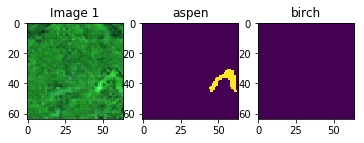

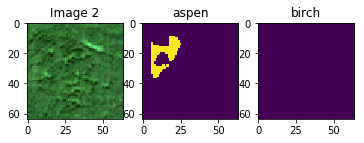

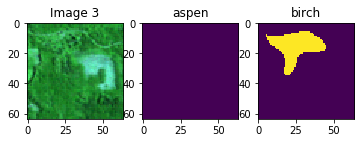

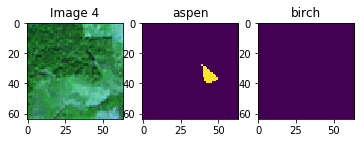

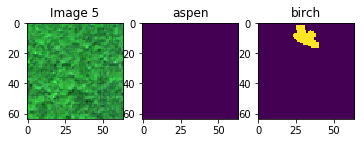

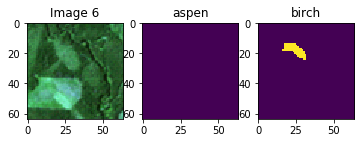

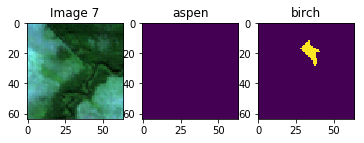

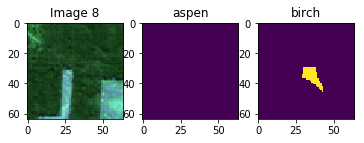

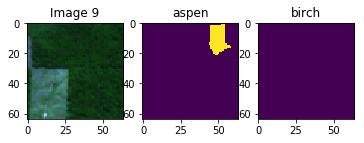

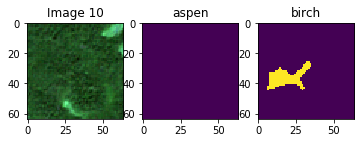

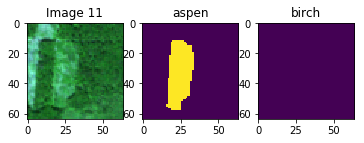

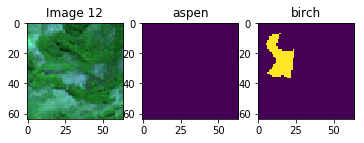

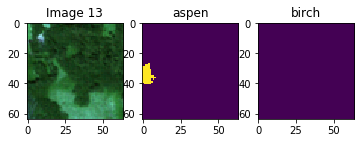

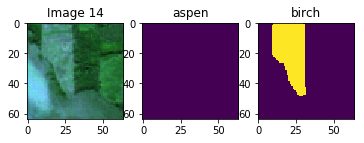

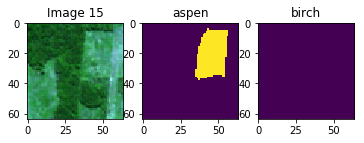

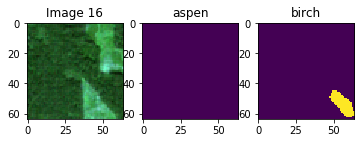

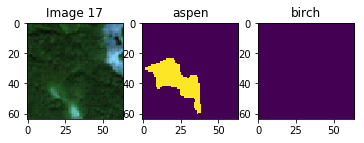

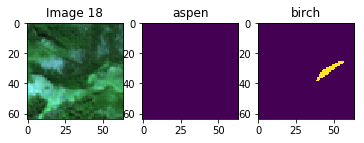

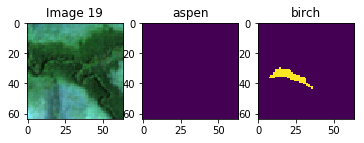

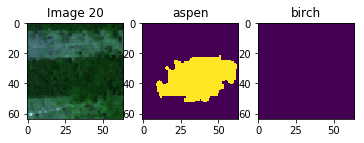

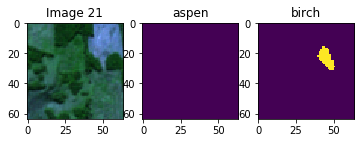

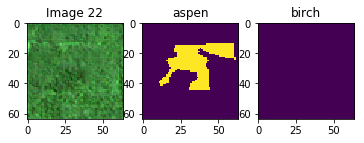

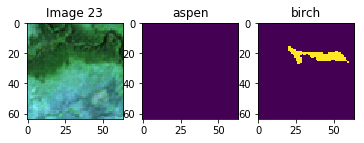

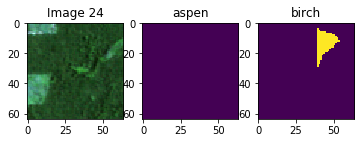

In [14]:
for num in range(1, 25):
    fig = plt.figure(figsize=(10, 10))
    a = fig.add_subplot(1, 5, 1)
    a.set_title('Image {}'.format(num))
    imgplot = plt.imshow((img[num, :, :, 0:3] - np.min(img[num, :, :, 0:3]))/(np.max(img[num, :, :, 0:3]) 
                                                                           - np.min(img[num, :, :, 0:3])) )
    a = fig.add_subplot(1, 5, 2)
    a.set_title('aspen')
    imgplot = plt.imshow(mask[num,:,:,0])
    a = fig.add_subplot(1, 5, 3)
    a.set_title('birch')
    imgplot = plt.imshow(mask[num,:,:,1])

Text(0.5,1,'class_1')

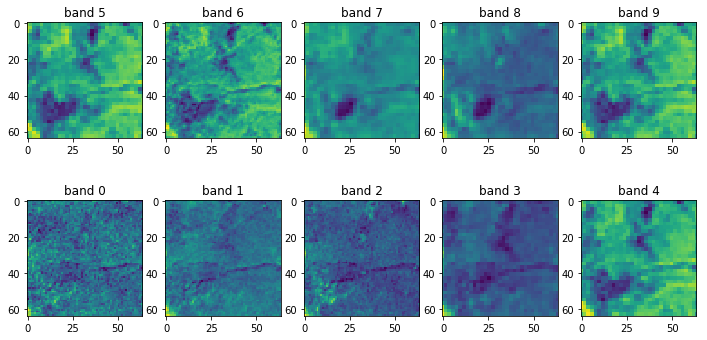

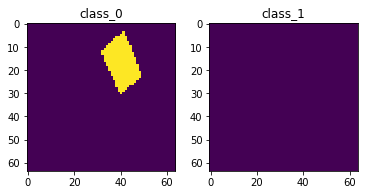

In [5]:
fig = plt.figure(figsize = (12,12))
for i in range(5):
    a = fig.add_subplot(1, 5, i+1)
    imgplot = plt.imshow(img_tmp[:,:,i])
    a.set_title('band '+str(i))

for i in range(5):
    a = fig.add_subplot(2, 5, i+1)
    imgplot = plt.imshow(img_tmp[:,:,5+i])
    a.set_title('band '+str(i+5))

fig = plt.figure(figsize = (6,6))
a = fig.add_subplot(2, 2, 1)
imgplot = plt.imshow(mask_tmp[:,:,0])
a.set_title('class_0')
a = fig.add_subplot(2, 2, 2)
imgplot = plt.imshow(mask_tmp[:,:,1])
a.set_title('class_1')

## Set model

In [16]:
model = Unet(backbone_name='resnet34', input_shape=(None, None, num_channels), classes=2,
                  encoder_weights=None, activation='softmax')
opt = RMSprop(lr=0.001)
metrics=[loss] 
model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [17]:
model_name = 'indiv_stand_AB_2m'
save_dir = '/home/user/data/example/data/Forestry_inventory/usgs_species_classification/'

# csv logger
log_filename = os.path.join(save_dir, '{}.csv'.format(model_name))
csv_logger = CSVLogger(log_filename, separator=',', append='True')

callbacks=[
    ReduceLROnPlateau(patience=2,min_lr=1e-9,verbose=1,mode='min'), 
    ModelCheckpoint(save_dir + '{}.h5'.format(model_name),save_best_only=True,verbose=1),
    ModelCheckpoint(save_dir + '{}.hdf5'.format(model_name),save_best_only=True,verbose=1, save_weights_only=True),
    csv_logger
]

In [18]:
history=model.fit_generator(generator.train_gen(),epochs=7, 
                           steps_per_epoch=100,
                           validation_data=generator.val_gen(),  
                           callbacks=callbacks, validation_steps=30)

Epoch 1/7
100/100 [==============================] - 296s 3s/step - loss: 0.8594 - loss_1: 0.8594 - val_loss: 9.1408 - val_loss_1: 9.1408

Epoch 00001: val_loss improved from inf to 9.14085, saving model to /home/user/data/example/data/Forestry_inventory/usgs_species_classification/indiv_stand_AB_2m.h5

Epoch 00001: val_loss improved from inf to 9.14085, saving model to /home/user/data/example/data/Forestry_inventory/usgs_species_classification/indiv_stand_AB_2m.hdf5
Epoch 2/7
100/100 [==============================] - 267s 3s/step - loss: 0.7539 - loss_1: 0.7539 - val_loss: 5.4046 - val_loss_1: 5.4046

Epoch 00002: val_loss improved from 9.14085 to 5.40460, saving model to /home/user/data/example/data/Forestry_inventory/usgs_species_classification/indiv_stand_AB_2m.h5

Epoch 00002: val_loss improved from 9.14085 to 5.40460, saving model to /home/user/data/example/data/Forestry_inventory/usgs_species_classification/indiv_stand_AB_2m.hdf5
Epoch 3/7
100/100 [=============================

In [20]:
history=model.fit_generator(generator.train_gen(),epochs=4,
                           steps_per_epoch=100,
                           validation_data=generator.val_gen(), 
                           callbacks=callbacks, validation_steps=30)

Epoch 1/4
100/100 [==============================] - 296s 3s/step - loss: 0.5180 - loss_1: 0.5180 - val_loss: 0.8868 - val_loss_1: 0.8868

Epoch 00001: val_loss did not improve from 0.83920

Epoch 00001: val_loss did not improve from 0.83920
Epoch 2/4
100/100 [==============================] - 272s 3s/step - loss: 0.5014 - loss_1: 0.5014 - val_loss: 0.7708 - val_loss_1: 0.7708

Epoch 00002: val_loss improved from 0.83920 to 0.77083, saving model to /home/user/data/example/data/Forestry_inventory/usgs_species_classification/indiv_stand_AB_2m.h5

Epoch 00002: val_loss improved from 0.83920 to 0.77083, saving model to /home/user/data/example/data/Forestry_inventory/usgs_species_classification/indiv_stand_AB_2m.hdf5
Epoch 3/4
100/100 [==============================] - 271s 3s/step - loss: 0.4790 - loss_1: 0.4790 - val_loss: 0.9760 - val_loss_1: 0.9760

Epoch 00003: val_loss did not improve from 0.77083

Epoch 00003: val_loss did not improve from 0.77083
Epoch 4/4
100/100 [=================

In [22]:
history=model.fit_generator(generator.train_gen(),epochs=3, 
                           steps_per_epoch=100,
                           validation_data=generator.val_gen(), 
                           callbacks=callbacks, validation_steps=30)

Epoch 1/3
100/100 [==============================] - 297s 3s/step - loss: 0.3612 - loss_1: 0.3612 - val_loss: 0.8127 - val_loss_1: 0.8127

Epoch 00001: val_loss did not improve from 0.77083

Epoch 00001: val_loss did not improve from 0.77083
Epoch 2/3
100/100 [==============================] - 274s 3s/step - loss: 0.3155 - loss_1: 0.3155 - val_loss: 0.8316 - val_loss_1: 0.8316

Epoch 00002: val_loss did not improve from 0.77083

Epoch 00002: val_loss did not improve from 0.77083
Epoch 3/3
100/100 [==============================] - 273s 3s/step - loss: 0.2929 - loss_1: 0.2929 - val_loss: 0.8489 - val_loss_1: 0.8489

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00003: val_loss did not improve from 0.77083

Epoch 00003: val_loss did not improve from 0.77083


In [31]:
# serialize model to JSON 
model_json = model.to_json()
with open(save_dir+"{}.json".format(model_name), "w") as json_file:
    json_file.write(model_json)
# serialize weights
model.save_weights(save_dir+"{}.h5".format(model_name))
print("Saved model to disk")

Saved model to disk


In [21]:
model.load_weights(save_dir+"{}.h5".format(model_name)) 

In [28]:
f1_score(generator.json_file_cl0_val, generator.json_file_cl1_val)

0.734
0.826


***
***

# Evaluation

In [23]:
for img, mask in generator.val_gen(): 
    break
pred = model.predict(img)

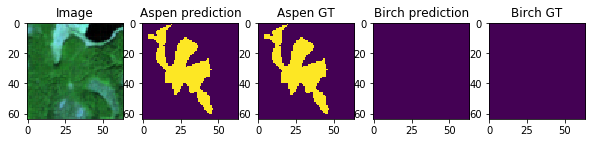

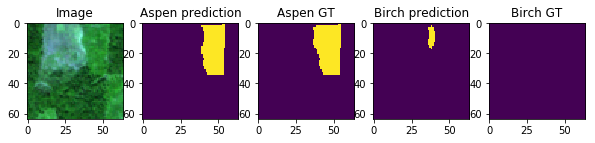

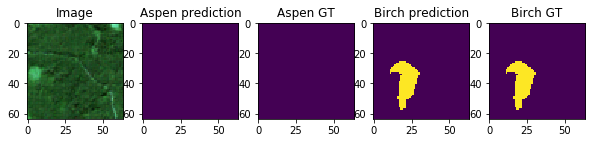

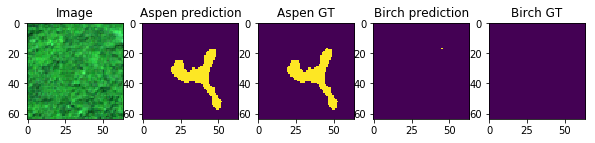

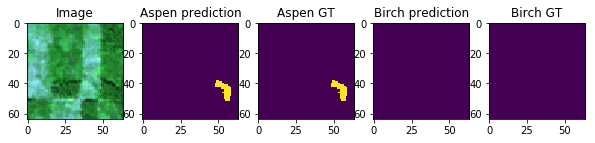

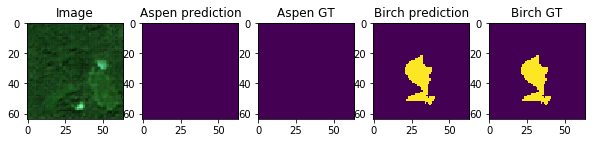

In [25]:
for num in range(6):
    fig = plt.figure(figsize=(10, 10))
    a = fig.add_subplot(1, 5, 1)
    a.set_title('Image')
    imgplot = plt.imshow((img[num, :, :, 0:3] - np.min(img[num, :, :, 0:3]))/(np.max(img[num, :, :, 0:3]) 
                                                                           - np.min(img[num, :, :, 0:3])) )
    a = fig.add_subplot(1, 5, 2)
    a.set_title('Aspen prediction')
    imgplot = plt.imshow(np.where(np.argmax(pred[num,:,:,:], axis=2)==0, 1, 0)*np.where(np.sum(mask[num,:,:,:], axis=2)>0, 1, 0)) #.imshow(pred[num,:,:,cl]>0.5) 
    a = fig.add_subplot(1, 5, 3)
    a.set_title('Aspen GT')
    imgplot = plt.imshow(mask[num,:,:,0])
    a = fig.add_subplot(1, 5, 4)
    a.set_title('Birch prediction')
    imgplot = plt.imshow(np.where(np.argmax(pred[num,:,:,:], axis=2)==1, 1, 0)*np.where(np.sum(mask[num,:,:,:], axis=2)>0, 1, 0)) #.imshow(pred[num,:,:,cl]>0.5) 
    a = fig.add_subplot(1, 5, 5)
    a.set_title('Birch GT')
    imgplot = plt.imshow(mask[num,:,:,1])

## Spruce and pine

In [34]:
class_0=['E']                         # spruce
class_1=['S']                         # pine
num_channels = 10
batch_size = 128 

generator = Generator(batch_size=batch_size,class_0=class_0,class_1=class_1,
                      num_channels=num_channels)

generator.IMG_COL = 64 
generator.IMG_ROW = 64 
generator.cloud = True
generator.augm = True
generator.stands_id = True
weights_list = [1., 1.5]
loss =  generator.weighted_categorical_crossentropy(weights_list)  

generator.load_dataset(folders=train_img_list,
                       json_name_cl0='E', json_name_cl1='S')

In [33]:
print('train (spruce, pine): ', len(generator.json_file_cl0_train), len(generator.json_file_cl1_train))
print('test (spruce, pine): ', len(generator.json_file_cl0_val), len(generator.json_file_cl1_val) )

train (spruce, pine):  1241 833
test (spruce, pine):  592 374


In [35]:
model = Unet(backbone_name='resnet34', input_shape=(None, None, num_channels), classes=2,
                  encoder_weights=None, activation='softmax')
opt = RMSprop(lr=0.001)
metrics=[loss] 
model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [11]:
model_name = 'indiv_stand_SP_2m'
save_dir = '/home/user/data/example/data/Forestry_inventory/usgs_species_classification/'

# csv logger
log_filename = os.path.join(save_dir, '{}.csv'.format(model_name))
csv_logger = CSVLogger(log_filename, separator=',', append='True')

callbacks=[
    ReduceLROnPlateau(patience=4,min_lr=1e-9,verbose=1,mode='min'), #pat 7
    ModelCheckpoint(save_dir + '{}.h5'.format(model_name),save_best_only=True,verbose=1),
    ModelCheckpoint(save_dir + '{}.hdf5'.format(model_name),save_best_only=True,verbose=1, save_weights_only=True),
    csv_logger
]

In [37]:
history=model.fit_generator(generator.train_gen(),epochs=15, # 15 35, 25 20
                           steps_per_epoch=100,#200,
                           validation_data=generator.val_gen(),  #(valid_imgarr,valid_maskarr),
                           callbacks=callbacks, validation_steps=30)#30

Epoch 1/15
100/100 [==============================] - 299s 3s/step - loss: 0.4625 - loss_1: 0.4625 - val_loss: 1.4204 - val_loss_1: 1.4204

Epoch 00001: val_loss improved from inf to 1.42038, saving model to /home/user/data/example/data/Forestry_inventory/usgs_species_classification/indiv_stand_SP_2m.h5

Epoch 00001: val_loss improved from inf to 1.42038, saving model to /home/user/data/example/data/Forestry_inventory/usgs_species_classification/indiv_stand_SP_2m.hdf5
Epoch 2/15
100/100 [==============================] - 266s 3s/step - loss: 0.3519 - loss_1: 0.3519 - val_loss: 5.6893 - val_loss_1: 5.6893

Epoch 00002: val_loss did not improve from 1.42038

Epoch 00002: val_loss did not improve from 1.42038
Epoch 3/15
100/100 [==============================] - 274s 3s/step - loss: 0.3369 - loss_1: 0.3369 - val_loss: 0.8538 - val_loss_1: 0.8538

Epoch 00003: val_loss improved from 1.42038 to 0.85382, saving model to /home/user/data/example/data/Forestry_inventory/usgs_species_classificat

KeyboardInterrupt: 

In [29]:
f1_score(generator.json_file_cl0_val, generator.json_file_cl1_val)

0.94
0.876


In [39]:
# serialize model to JSON 
model_json = model.to_json()
with open(save_dir+"{}.json".format(model_name), "w") as json_file:
    json_file.write(model_json)
# serialize weights
model.save_weights(save_dir+"{}.h5".format(model_name))
print("Saved model to disk")

Saved model to disk


### Check intersection between train and val samples

In [39]:
samples_val = []
for key in generator.json_file_cl0_val.keys():
    sample = generator.json_file_cl0_val[key]
    samples_val.append([key.split('_')[0], sample['upper_left_x'], sample['upper_left_y'], sample['pol_width'], sample['pol_height']])
    
samples_train = []
for key in generator.json_file_cl0_train.keys():
    sample = generator.json_file_cl0_train[key]
    samples_train.append([key.split('_')[0], sample['upper_left_x'], sample['upper_left_y'], sample['pol_width'], sample['pol_height']])

In [40]:
k = 0
for sample in samples_val:
    if sample in samples_train:
        k += 1
k

0